[*********************100%***********************]  1 of 1 completed


Columns in db: [('Close', 'MSFT'), ('High', 'MSFT'), ('Low', 'MSFT'), ('Open', 'MSFT'), ('Volume', 'MSFT')]
Missing columns (should be empty): []

MAE (model): 4.2861
RMSE (model): 5.8904
Baseline MAE: 4.0529
Baseline RMSE: 5.6860

Last 5 days comparison:
            Actual Close  Predicted Close  Error (Actual - Predicted)
Date                                                                 
2025-08-19    508.933350       518.305897                   -9.372547
2025-08-20    504.890015       512.223533                   -7.333518
2025-08-21    504.239990       508.583223                   -4.343233
2025-08-22    507.230011       507.306102                   -0.076091
2025-08-25    504.260010       508.616001                   -4.355991


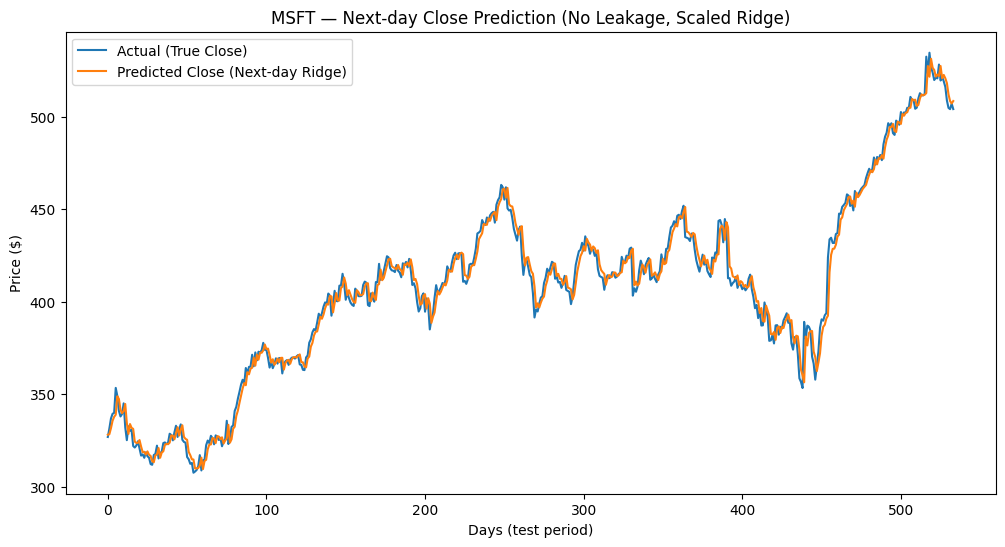


Predicted next-day Close for 2025-08-26: 508.62
Last known Close (2025-08-25): 504.26
Expected change: +4.36 USD


C:\Users\DELL\AppData\Local\Temp\ipykernel_15392\1057204524.py:101: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close = float(y.iloc[-1])    # حوله لعدد عائم لتنسيق .2f


In [3]:
# --- إعادة كل شيء من الصفر بشكل متماسك ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.tseries.offsets import BDay

# 1) تنزيل البيانات
db = yf.download("MSFT", start="2015-01-01", interval="1d", auto_adjust=True)
db = db.dropna()

# فحص الأعمدة المتاحة
print("Columns in db:", list(db.columns))  # يجب أن ترى: ['Open','High','Low','Close','Volume'] (مع auto_adjust=True)

# 2) بناء الميزات بدون تسرب بيانات (shift(1) لكل الميزات)
df = db.copy()

df["Close_lag1"] = df["Close"].shift(1)                          # إغلاق أمس
df["MA5"]        = df["Close"].rolling(5).mean().shift(1)        # MA5 منتهي أمس
df["MA10"]       = df["Close"].rolling(10).mean().shift(1)       # MA10 منتهي أمس
df["High_Low"]   = (df["High"] - df["Low"]).shift(1)             # مدى اليوم السابق
df["Volume_lag1"]= df["Volume"].shift(1)                         # حجم تداول أمس
df["Volatility5"]= df["Close"].pct_change().rolling(5).std().shift(1)  # تذبذب 5 أيام منتهي أمس

# خليها بسيطة: بما إن الأعمدة اللي أضفناها فيها NaN بالبدايات، احذف أي صف فيه NaN
df = df.dropna().copy()

# تأكد أن الأعمدة موجودة الآن
feature_cols = ["Close_lag1","MA5","MA10","Volume_lag1","High_Low","Volatility5"]
missing = [c for c in feature_cols + ["Close"] if c not in df.columns]
print("Missing columns (should be empty):", missing)

# 3) إعداد X و y
X = df[feature_cols]
y = df["Close"]  # سلسلة 1D

# 4) تقسيم زمني يدوي (80/20)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 5) نموذج خطي محسن (Scaling + Ridge)
model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 6) تقييم ضد الحقيقة وضد baseline (Close_lag1)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
baseline_pred = X_test["Close_lag1"].values
mae_base  = mean_absolute_error(y_test, baseline_pred)
rmse_base = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"\nMAE (model): {mae:.4f}")
print(f"RMSE (model): {rmse:.4f}")
print(f"Baseline MAE: {mae_base:.4f}")
print(f"Baseline RMSE: {rmse_base:.4f}")

# 7) جدول آخر 5 أيام (حقيقة/توقع/خطأ)
y_test_series = pd.Series(np.asarray(y_test).ravel(), index=y_test.index)
y_pred_series = pd.Series(np.asarray(y_pred).ravel(), index=y_test.index)

results_tail = pd.concat([
    y_test_series.rename("Actual Close").tail(5),
    y_pred_series.rename("Predicted Close").tail(5),
], axis=1)
results_tail["Error (Actual - Predicted)"] = (
    results_tail["Actual Close"] - results_tail["Predicted Close"]
)
print("\nLast 5 days comparison:")
print(results_tail)

# 8) رسم المقارنة على فترة الاختبار
plt.figure(figsize=(12,6))
plt.plot(y_test_series.values, label="Actual (True Close)")
plt.plot(y_pred_series.values, label="Predicted Close (Next-day Ridge)")
plt.title("MSFT — Next-day Close Prediction (No Leakage, Scaled Ridge)")
plt.xlabel("Days (test period)")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# 9) التنبؤ بسعر إغلاق الغد (يوم العمل التالي) من آخر يوم متاح
from pandas.tseries.offsets import BDay

last_date = df.index[-1]          # آخر تاريخ لدينا ميزاته
X_next = X.iloc[[-1]].copy()      # حافظ على DataFrame + أسماء الأعمدة
next_close_pred = model.predict(X_next)[0]

# اطبع التوقع وتفاصيل آخر إغلاق معروف
print(f"\nPredicted next-day Close for { (last_date + BDay(1)).date() }: {next_close_pred:.2f}")

last_close = float(y.iloc[-1])    # حوله لعدد عائم لتنسيق .2f
print(f"Last known Close ({last_date.date()}): {last_close:.2f}")
print(f"Expected change: {next_close_pred - last_close:+.2f} USD")
